In [ ]:
!pip install xgboost catboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt


In [ ]:
# Synthetic dataset for ranking
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
group = [50] * 20  # Define groups of size 50 each (20 groups)


In [ ]:
# preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate group_train and group_test with the correct format for LightGBM
# LightGBM expects the group to represent the number of samples in each group, not the group ID
group_train = [50] * (len(X_train) // 50)  # Assuming 50 items per group
group_test = [50] * (len(X_test) // 50)  # Assuming 50 items per group

y_test_rank = []
for i in range(0, len(y_test), 50):  # Iterate over groups of size 50
    group_indices = np.arange(i, min(i + 50, len(y_test)))
    group_ranks = np.argsort(y_test[group_indices]) + 1  # Rank within the group
    y_test_rank.extend(group_ranks)

y_test = np.array(y_test_rank).astype(int)


In [ ]:
from xgboost import XGBRanker
xgb = XGBRanker(objective="rank:pairwise", learning_rate=0.1, n_estimators=100)
xgb.fit(X_train, y_train, group=group_train)
y_pred_xgb = xgb.predict(X_test)
ndcg_xgb = ndcg_score([y_test], [y_pred_xgb])
print("XGBoost NDCG Score:", ndcg_xgb)


XGBoost NDCG Score: 0.9222684212781938


In [ ]:
from catboost import CatBoostRanker
cat = CatBoostRanker(iterations=100, learning_rate=0.1, verbose=0)
cat.fit(X_train, y_train, group_id=group_train)
y_pred_cat = cat.predict(X_test)
ndcg_cat = ndcg_score([y_test], [y_pred_cat])
print("CatBoost NDCG Score:", ndcg_cat)


CatBoost NDCG Score: 0.9270417479295564


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to ranks
n_bins = 5
kbins = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")
y_train_ranked = kbins.fit_transform(y_train.reshape(-1, 1)).astype(int).ravel()
y_test_ranked = kbins.transform(y_test.reshape(-1, 1)).astype(int).ravel()

# Define query groups
group_size = 50
group_train = [group_size] * (len(X_train) // group_size) + ([len(X_train) % group_size] if len(X_train) % group_size > 0 else [])
group_test = [group_size] * (len(X_test) // group_size) + ([len(X_test) % group_size] if len(X_test) % group_size > 0 else [])

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train_ranked, group=group_train)
test_data = lgb.Dataset(X_test, label=y_test_ranked, group=group_test, reference=train_data)

# Define parameters
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "label_gain": [0, 1, 3, 7, 15],  # Define gain for each rank
}

# Train the model
lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [ ]:
# Train the LightGBM model
lgbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test)

# Compute NDCG score
ndcg_lgbm = ndcg_score([y_test_ranked], [y_pred_lgbm])
print("LightGBM NDCG Score:", ndcg_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
results = {
    "Model": ["XGBoost", "CatBoost", "LightGBM"],
    "NDCG Score": [ndcg_xgb, ndcg_cat, ndcg_lgbm]
}
results_df = pd.DataFrame(results)
print(results_df)


      Model  NDCG Score
0   XGBoost    0.922268
1  CatBoost    0.927042
2  LightGBM    0.988961


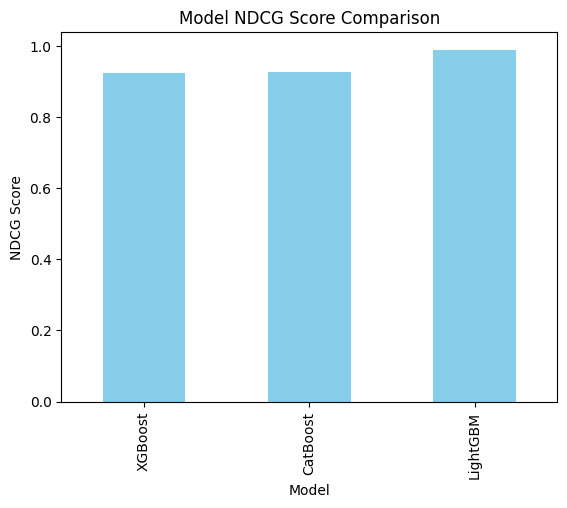

In [ ]:
results_df.plot(kind="bar", x="Model", y="NDCG Score", legend=False, color="skyblue")
plt.title("Model NDCG Score Comparison")
plt.ylabel("NDCG Score")
plt.show()
